# Fuel Prices in NSW
## Fuel Stations and Fuel Depots

The relationship between fuel stations and fuel depots. We'll have a look at whether fuel will be cheaper if a station is closer to a depot compare to ones that isn't near one.

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gp
import fiona
import os
from datetime import datetime
import geopy
from geopy.geocoders import Nominatim
import shapely
import folium
from folium import Marker

shp_file_name = "NSW_LOC_POLYGON_shp/NSW_LOC_POLYGON_shp.shp"
zip_file_name = "nsw_loc_polygon_shp.zip"
web_file_path = (
    "https://data.gov.au/data/dataset/"
    "91e70237-d9d1-4719-a82f-e71b811154c6/resource/"
    "5e295412-357c-49a2-98d5-6caf099c2339/download/"
    "nsw_locality_polygon_shp.zip")

new_fuel_station_coordinates = pd.read_csv("price_history_checks_may2021.csv")
fuel_stations = pd.read_excel("price_history_checks_may2021.xlsx")
fuel_depots = pd.read_csv("LiquidFuelDepots_v1.csv")
fuel_station_coordinates = pd.read_csv("stations_lat_long.csv")

print("done")


done


In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['figure.dpi'] = 100


In [4]:
# give us a style state to go back to
saved_style_state = matplotlib.rcParams.copy()


In [5]:
def unzip_zipfile(zipped_file_path, put_it_here="."):
    import zipfile
    zip_of_suburbs = zipfile.ZipFile(zipped_file_path, 'r')
    zip_of_suburbs.extractall(put_it_here)
    zip_of_suburbs.close()


In [6]:
if os.path.isfile(shp_file_name):
    print("loading from file")
else:
    if os.path.isfile(zip_file_name):
        print("unzipping")
        unzip_zipfile(zip_file_name)
    else:
        import requests
        print("loading from the internet")
        page = requests.get(web_file_path)
        with open(zip_file_name, 'wb') as z:
            z.write(page.content)
        unzip_zipfile(zip_file_name)

print("done")


loading from file
done


In [7]:
burbs = gp.GeoDataFrame.from_file(shp_file_name)
burbs.set_crs(epsg=5234, inplace=True, allow_override=True)
# https://epsg.io/8021
# GDA2020 is the latest and least wrong coord set for Sydney
burbs.sample(2)


LC_PLY_PID   DT_CREATE DT_RETIRE  LOC_PID  NSW_LOCALI NSW_LOCA_1  \
402      34860  2021-02-09      None  NSW3721  2017-05-02       None   
249      35277  2021-02-09      None   NSW903  2017-08-10       None   

      NSW_LOCA_2 NSW_LOCA_3 NSW_LOCA_4 NSW_LOCA_5 NSW_LOCA_6 NSW_LOCA_7  \
402  SUMMER HILL       None       2130          G       None          1   
249   CHARMHAVEN       None       None          G       None          1   

                                              geometry  
402  POLYGON ((151.13203 -33.90089, 151.13193 -33.9...  
249  POLYGON ((151.49216 -33.20995, 151.49223 -33.2...

This is the original data frame

In [8]:
fuel_stations.head(10)

ServiceStationName                                       Address  \
0  Metro Fuel Killarney Heights  702-704 Warringah Road, Forestville NSW 2087   
1                           NaN                                           NaN   
2                           NaN                                           NaN   
3              Caltex Cambridge     Lot 6 Star Court, CAMBRIDGE PARK NSW 2747   
4            Westside Adamstown            125 Brunker Rd, Adamstown NSW 2289   
5                           NaN                                           NaN   
6       Metro Petroleum Ballina            323 River Street, BALLINA NSW 2478   
7                           NaN                                           NaN   
8                           NaN                                           NaN   
9                           NaN                                           NaN   

           Suburb  Postcode       Brand FuelCode       PriceUpdatedDate  Price  
0     Forestville    2087.0  Metro Fuel      U91  1/05/2021 12:01:20 AM  137.9  
1             NaN       NaN         NaN      E10  1/05/2021 12:01:20 AM  135.9  
2             NaN       NaN         NaN      P98  1/05/2021 12:01:20 AM  155.9  
3  CAMBRIDGE PARK    2747.0      Caltex      P95  1/05/2021 12:06:09 AM  152.9  
4       Adamstown    2289.0    Westside       DL  1/05/2021 12:07:01 AM  136.9  
5             NaN       NaN         NaN      P98  1/05/2021 12:07:01 AM  158.9  
6         BALLINA    2478.0  Metro Fuel      E10  1/05/2021 12:14:40 AM  139.9  
7             NaN       NaN         NaN      PDL  1/05/2021 12:14:40 AM  137.9  
8             NaN       NaN         NaN      P98  1/05/2021 12:14:40 AM  161.9  
9             NaN       NaN         NaN      U91  1/05/2021 12:14:40 AM  142.9

In [9]:
def dateparser(x): return pd.to_datetime(x, dayfirst=True)


price_df = pd.read_excel(
    "price_history_checks_may2021.xlsx", parse_dates=["PriceUpdatedDate"], date_parser=dateparser
)

price_df.head()


ServiceStationName                                       Address  \
0  Metro Fuel Killarney Heights  702-704 Warringah Road, Forestville NSW 2087   
1                           NaN                                           NaN   
2                           NaN                                           NaN   
3              Caltex Cambridge     Lot 6 Star Court, CAMBRIDGE PARK NSW 2747   
4            Westside Adamstown            125 Brunker Rd, Adamstown NSW 2289   

           Suburb  Postcode       Brand FuelCode    PriceUpdatedDate  Price  
0     Forestville    2087.0  Metro Fuel      U91 2021-05-01 00:01:20  137.9  
1             NaN       NaN         NaN      E10 2021-05-01 00:01:20  135.9  
2             NaN       NaN         NaN      P98 2021-05-01 00:01:20  155.9  
3  CAMBRIDGE PARK    2747.0      Caltex      P95 2021-05-01 00:06:09  152.9  
4       Adamstown    2289.0    Westside       DL 2021-05-01 00:07:01  136.9

In [10]:
fuel_codes = price_df.FuelCode.unique()
fuel_codes = [x for x in fuel_codes if type(x) is str]
print(fuel_codes)

new_column_names = (
    [f"Price_{name}_UpdatedDate" for name in fuel_codes]
    + [f"Price_{name}" for name in fuel_codes]
    + [
        name
        for name in price_df.columns
        if name not in ["FuelCode", "PriceUpdatedDate", "Price"]
    ]
)
new_column_names.sort()
print(new_column_names)
new_rows = []
temp_row = pd.Series(index=new_column_names, dtype=object)

for i, row in price_df.iterrows():
    fc = row.FuelCode
    if row.ServiceStationName is not np.NaN:
        new_rows.append(temp_row)
        temp_row = pd.Series(index=new_column_names, dtype=object)
        for key, element in row.iteritems():
            if key in temp_row.index:
                temp_row[key] = element
        temp_row[f"Price_{fc}_UpdatedDate"] = row.PriceUpdatedDate
        temp_row[f"Price_{fc}"] = row.Price
    elif row.ServiceStationName is np.NaN:
        temp_row[f"Price_{fc}_UpdatedDate"] = row.PriceUpdatedDate
        temp_row[f"Price_{fc}"] = row.Price

reshaped_df = pd.DataFrame(new_rows)
reshaped_df.drop([0], inplace=True)


['U91', 'E10', 'P98', 'P95', 'DL', 'PDL', 'LPG', 'E85']
['Address', 'Brand', 'Postcode', 'Price_DL', 'Price_DL_UpdatedDate', 'Price_E10', 'Price_E10_UpdatedDate', 'Price_E85', 'Price_E85_UpdatedDate', 'Price_LPG', 'Price_LPG_UpdatedDate', 'Price_P95', 'Price_P95_UpdatedDate', 'Price_P98', 'Price_P98_UpdatedDate', 'Price_PDL', 'Price_PDL_UpdatedDate', 'Price_U91', 'Price_U91_UpdatedDate', 'ServiceStationName', 'Suburb']


Reshaping the data frame

In [11]:
reshaped_df.head()

Address       Brand  Postcode  \
1  702-704 Warringah Road, Forestville NSW 2087  Metro Fuel    2087.0   
2     Lot 6 Star Court, CAMBRIDGE PARK NSW 2747      Caltex    2747.0   
3            125 Brunker Rd, Adamstown NSW 2289    Westside    2289.0   
4            323 River Street, BALLINA NSW 2478  Metro Fuel    2478.0   
5      656 Warringah Road, FORESTVILLE NSW 2087  Metro Fuel    2087.0   

   Price_DL Price_DL_UpdatedDate  Price_E10 Price_E10_UpdatedDate  Price_E85  \
1       NaN                  NaT      135.9   2021-05-01 00:01:20        NaN   
2       NaN                  NaT        NaN                   NaT        NaN   
3     136.9  2021-05-01 00:07:01        NaN                   NaT        NaN   
4       NaN                  NaT      139.9   2021-05-01 00:14:40        NaN   
5       NaN                  NaT      135.9   2021-05-01 00:15:42        NaN   

  Price_E85_UpdatedDate  Price_LPG  ... Price_P98  Price_P98_UpdatedDate  \
1                   NaT        NaN  ...     155.9    2021-05-01 00:01:20   
2                   NaT        NaN  ...       NaN                    NaT   
3                   NaT        NaN  ...     158.9    2021-05-01 00:07:01   
4                   NaT        NaN  ...     161.9    2021-05-01 00:14:40   
5                   NaT        NaN  ...       NaN                    NaT   

  Price_PDL  Price_PDL_UpdatedDate Price_U91  Price_U91_UpdatedDate  \
1       NaN                    NaT     137.9    2021-05-01 00:01:20   
2       NaN                    NaT       NaN                    NaT   
3       NaN                    NaT       NaN                    NaT   
4     137.9    2021-05-01 00:14:40     142.9    2021-05-01 00:14:40   
5       NaN                    NaT     137.9    2021-05-01 00:15:42   

             ServiceStationName          Suburb Price_nan_UpdatedDate  \
1  Metro Fuel Killarney Heights     Forestville                   NaT   
2              Caltex Cambridge  CAMBRIDGE PARK                   NaT   
3            Westside Adamstown       Adamstown                   NaT   
4       Metro Petroleum Ballina         BALLINA                   NaT   
5   Metro Petroleum Forestville     FORESTVILLE                   NaT   

  Price_nan  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
5       NaN  

[5 rows x 23 columns]

To generate maps, we'll have to locate the latitude and longitude with geoLocator

In [12]:
# geolocator = Nominatim(timeout=10, user_agent= "myGeolocator")
# stations = []
# for station in reshaped_df.Address.unique():
#     try:
#         location = geolocator.geocode(station)
#         print(location.longitude, location.latitude)
#         di = {"station":station, "location":location, "latitude":location.latitude, "longitude":location.longitude}
#     except Exception as e:
#         di = {"station":station, "location":None, "latitude":None, "longitude":None, "Error":e}
#     stations.append(di)
    


Saving the file saved up a lot of time instead of downloading the data from the API again.

In [13]:
# station_df = pd.DataFrame(stations)
# station_df.to_csv("stations_lat_long.csv")

Final dataframe

In [14]:
def shapely_new_depots(row):
    return shapely.geometry.point.Point(row.LONGITUDE, row.LATITUDE)


fuel_depots["geometry"] = fuel_depots.apply(shapely_new_depots, axis=1)
fuel_depots.head()


OBJECTID FEATURETYPE                                        DESCRIPTION  \
0         1  Fuel Depot  A facility used for the bulk storage of petrol...   
1         2  Fuel Depot  A facility used for the bulk storage of petrol...   
2         3  Fuel Depot  A facility used for the bulk storage of petrol...   
3         4  Fuel Depot  A facility used for the bulk storage of petrol...   
4         5  Fuel Depot  A facility used for the bulk storage of petrol...   

        CLASS  FID                      NAME OPERATIONALSTATUS  \
0  Fuel Depot   52                      Eden       Operational   
1  Fuel Depot   53  Temora Fuel Distributors       Operational   
2  Fuel Depot   54                     Dubbo       Operational   
3  Fuel Depot   55                     Dubbo       Operational   
4  Fuel Depot   56                     Dubbo       Operational   

                   OPERATOR   OWNER                 ADDRESS  SUBURB  \
0                    Caltex  Caltex   Lot 23 Ben Boyd Drive    Eden   
1  Temora Fuel Distributors      BP       9 Ironbark Street  Temora   
2          Inland Petroleum      BP      105 Erskine Street   Dubbo   
3   Lowes Petroleum Service   Mobil      107 Erskine Street   Dubbo   
4                     Shell   Shell  109-113 Erskine Street   Dubbo   

             STATE  SPATIALCONFIDENCE   REVISED  \
0  New South Wales                  4  20121004   
1  New South Wales                  5  20121004   
2  New South Wales                  5  20121004   
3  New South Wales                  5  20121004   
4  New South Wales                  5  20121004   

                                             COMMENT   LATITUDE   LONGITUDE  \
0  8 lay Down tanks + 1 lay down tank possibly fo... -37.038479  149.891540   
1  3 med + 1 med + 1 separate lay down tank, 2 me... -34.447685  147.552978   
2  Station as well, 1 Terminal sized upright + 10... -32.244324  148.610268   
3  Station as well, 5 large + 2 small upright tan... -32.244473  148.611153   
4  Station as well, 1 terminal sized + 1 small up... -32.244732  148.612396   

                           geometry  
0  POINT (149.8915405 -37.03847885)  
1  POINT (147.5529785 -34.44768524)  
2  POINT (148.6102676 -32.24432373)  
3   POINT (148.6111526 -32.2444725)  
4   POINT (148.6123962 -32.2447319)

In [15]:
def shapely_new_stations(row):
    return shapely.geometry.point.Point(row.longitude, row.latitude)


fuel_station_coordinates["geometry"] = fuel_station_coordinates.apply(
    shapely_new_stations, axis=1)
fuel_station_coordinates.head()

Number                                       station  \
0       0  702-704 Warringah Road, Forestville NSW 2087   
1       2            125 Brunker Rd, Adamstown NSW 2289   
2       3            323 River Street, BALLINA NSW 2478   
3       4      656 Warringah Road, FORESTVILLE NSW 2087   
4       5          198 Hill End Road, Doonside NSW 2767   

                                            location   latitude   longitude  \
0  Warringah Road, Forestville, Sydney, Northern ... -33.760921  151.216115   
1  Brunker Road, Adamstown, Newcastle, Newcastle ... -32.943960  151.722761   
2  323, River Street, Ballina CBD, Ballina, Balli... -28.866000  153.550280   
3  Warringah Road, Forestville, Sydney, Northern ... -33.760921  151.216115   
4  Hill End Road, Doonside, Sydney, Blacktown Cit... -33.761139  150.869841   

        owner            Price_U91        Price_P98  \
0  Metro Fuel                137.9            155.9   
1    Westside  Not Selling U91                158.9   
2  Metro Fuel                142.9            161.9   
3  Metro Fuel                137.9  Not Selling P98   
4  Metro Fuel  Not Selling U91      Not Selling P98   

                           geometry  
0   POINT (151.2161153 -33.7609212)  
1   POINT (151.7227611 -32.9439598)  
2  POINT (153.5502802 -28.86600025)  
3   POINT (151.2161153 -33.7609212)  
4   POINT (150.8698407 -33.7611391)

In [16]:
fuel_station_coordinates_geo = gp.GeoDataFrame(fuel_station_coordinates)
fuel_depots_geo = gp.GeoDataFrame(fuel_depots)

In [17]:
def fuel_depot_owners_graph():
    fuel_depot_data = fuel_depots["OWNER"].value_counts()
    fuel_depot_data.plot.barh(fontsize=10)
    plt.title("Amount of fuel depots owned by companies", fontsize=20)
    plt.xlabel("Number of Depots", fontsize=10)
    plt.ylabel("Company Name", fontsize=10)


We first start with the depots owned by companies. 

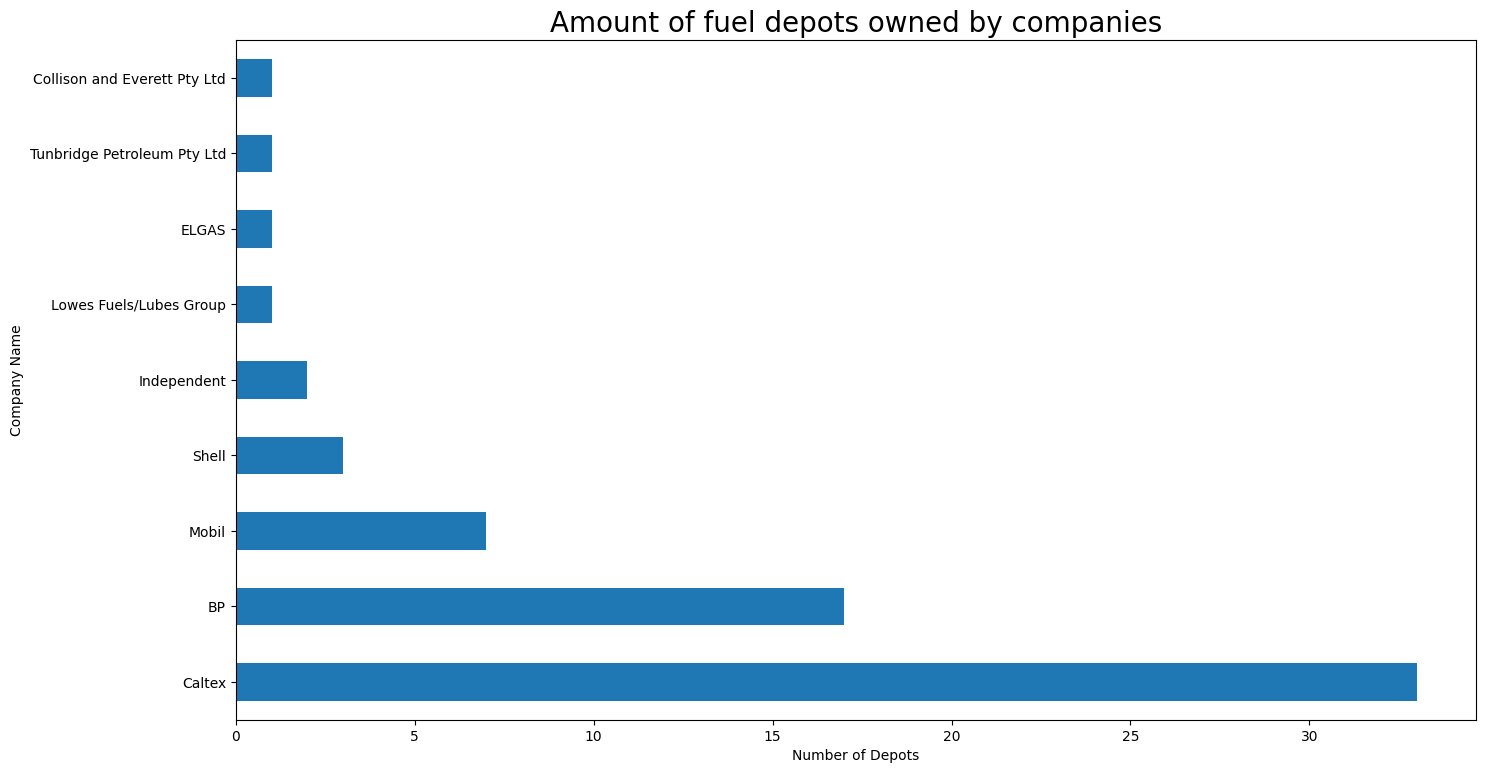

In [18]:
fuel_depot_owners_graph()

As you can see, Caltex owned the most amount of fuel depots following by BP, Mobil and Shell. Caltex owned more depots than all BP, Mobil and Shell combined. Interestingly you can't find Coles anywhere. Oh also one of the depots was owned by a truck repair company.

This raised a question. Since Caltex has so many depots, will they have a cheaper fuel price selling at the fuel station?
How about Coles, what whould the relationship be?

In [19]:
reshaped_df["Address_Brand"] = reshaped_df.apply(lambda row: f"{row.Address} {row.Brand}", axis =1)

In [20]:
df_withtime = reshaped_df[(reshaped_df.Price_U91_UpdatedDate > "2021-05-01 00:07:01")
                 & (reshaped_df.Price_U91_UpdatedDate < "2021-05-31 23:59:59")]
price_frame_df = df_withtime[df_withtime.Price_U91>160]
price_frame_df.head()

Address          Brand  \
159            2-14 Henry Lawson Dr, TERRANORA NSW 2486    Independent   
1420            22-26 Pearl Street, Kingscliff NSW 2487    Independent   
4053            22-26 Pearl Street, Kingscliff NSW 2487    Independent   
4683  Weakleys Dr Cnr Balook Dr, Beresfield North NS...          Ampol   
4741                93 WEAKLEYS DR, BERESFIELD NSW 2322  Coles Express   

      Postcode  Price_DL Price_DL_UpdatedDate  Price_E10  \
159     2486.0       NaN                  NaT      167.9   
1420    2487.0       NaN                  NaT      167.9   
4053    2487.0       NaN                  NaT      159.9   
4683    2322.0       NaN                  NaT        NaN   
4741    2322.0       NaN                  NaT      158.9   

     Price_E10_UpdatedDate  Price_E85 Price_E85_UpdatedDate  Price_LPG  ...  \
159    2021-05-01 08:55:42        NaN                   NaT        NaN  ...   
1420   2021-05-03 09:05:55        NaN                   NaT        NaN  ...   
4053   2021-05-06 09:56:08        NaN                   NaT        NaN  ...   
4683                   NaT        NaN                   NaT        NaN  ...   
4741   2021-05-07 09:30:51        NaN                   NaT        NaN  ...   

     Price_P98_UpdatedDate  Price_PDL Price_PDL_UpdatedDate  Price_U91  \
159    2021-05-01 08:55:42        NaN                   NaT      169.9   
1420                   NaT        NaN                   NaT      169.9   
4053                   NaT        NaN                   NaT      161.9   
4683                   NaT        NaN                   NaT      160.1   
4741   2021-05-07 09:30:51        NaN                   NaT      160.9   

     Price_U91_UpdatedDate        ServiceStationName            Suburb  \
159    2021-05-01 08:55:42   Freedom Fuels Terranora         TERRANORA   
1420   2021-05-03 09:05:55    Independent Kingscliff        Kingscliff   
4053   2021-05-06 09:56:08    Independent Kingscliff        Kingscliff   
4683   2021-05-07 08:48:36    AMPOL Beresfield North  Beresfield North   
4741   2021-05-07 09:30:51  Coles Express Beresfield        BERESFIELD   

      Price_nan_UpdatedDate Price_nan  \
159                     NaT       NaN   
1420                    NaT       NaN   
4053                    NaT       NaN   
4683                    NaT       NaN   
4741                    NaT       NaN   

                                          Address_Brand  
159   2-14 Henry Lawson Dr, TERRANORA NSW 2486 Indep...  
1420  22-26 Pearl Street, Kingscliff NSW 2487 Indepe...  
4053  22-26 Pearl Street, Kingscliff NSW 2487 Indepe...  
4683  Weakleys Dr Cnr Balook Dr, Beresfield North NS...  
4741  93 WEAKLEYS DR, BERESFIELD NSW 2322 Coles Express  

[5 rows x 24 columns]

In [21]:
df_withtime = reshaped_df[(reshaped_df.Price_U91_UpdatedDate > "2021-05-01 00:07:01")
                 & (reshaped_df.Price_U91_UpdatedDate < "2021-05-31 23:59:59")]
price_frame_df_low = df_withtime[df_withtime.Price_U91<130]
price_frame_df_low.head()

Address       Brand  Postcode  \
12  332-336 Shellharbour Rd, BARRACK HEIGHTS NSW 2528       Ampol    2528.0   
17                  6b 1-10 Amy Close, WYONG NSW 2259  Metro Fuel    2259.0   
18                 150 Pacific Hwy, TUGGERAH NSW 2259  Metro Fuel    2259.0   
19                 380 Wollombi Rd, BELLBIRD NSW 2325  Metro Fuel    2325.0   
23                 102 Wollombi Rd, CESSNOCK NSW 2325  Metro Fuel    2325.0   

    Price_DL Price_DL_UpdatedDate  Price_E10 Price_E10_UpdatedDate  Price_E85  \
12       NaN                  NaT      125.9   2021-05-01 02:32:49        NaN   
17     125.9  2021-05-01 04:27:01      122.9   2021-05-01 04:27:01        NaN   
18       NaN                  NaT      122.9   2021-05-01 04:29:29        NaN   
19       NaN                  NaT      124.5   2021-05-01 04:50:56        NaN   
23       NaN                  NaT      122.9   2021-05-01 05:01:18        NaN   

   Price_E85_UpdatedDate  Price_LPG  ... Price_P98_UpdatedDate  Price_PDL  \
12                   NaT        NaN  ...   2021-05-01 02:32:49        NaN   
17                   NaT        NaN  ...                   NaT        NaN   
18                   NaT        NaN  ...                   NaT      126.9   
19                   NaT        NaN  ...                   NaT        NaN   
23                   NaT        NaN  ...                   NaT        NaN   

   Price_PDL_UpdatedDate  Price_U91 Price_U91_UpdatedDate  \
12                   NaT      127.9   2021-05-01 02:32:49   
17                   NaT      124.9   2021-05-01 04:27:01   
18   2021-05-01 04:29:29      124.9   2021-05-01 04:29:29   
19                   NaT      126.5   2021-05-01 04:50:56   
23                   NaT      124.9   2021-05-01 05:01:18   

          ServiceStationName           Suburb  Price_nan_UpdatedDate  \
12     Ampol Barrack Heights  BARRACK HEIGHTS                    NaT   
17         Metro North Wyong            WYONG                    NaT   
18            Metro Tuggerah         TUGGERAH                    NaT   
19  Metro Petroleum Bellbird         BELLBIRD                    NaT   
23            Metro Cessnock         CESSNOCK                    NaT   

   Price_nan                                      Address_Brand  
12       NaN  332-336 Shellharbour Rd, BARRACK HEIGHTS NSW 2...  
17       NaN       6b 1-10 Amy Close, WYONG NSW 2259 Metro Fuel  
18       NaN      150 Pacific Hwy, TUGGERAH NSW 2259 Metro Fuel  
19       NaN      380 Wollombi Rd, BELLBIRD NSW 2325 Metro Fuel  
23       NaN      102 Wollombi Rd, CESSNOCK NSW 2325 Metro Fuel  

[5 rows x 24 columns]

Text(0.5, 1.0, 'Fuel Station Prices')

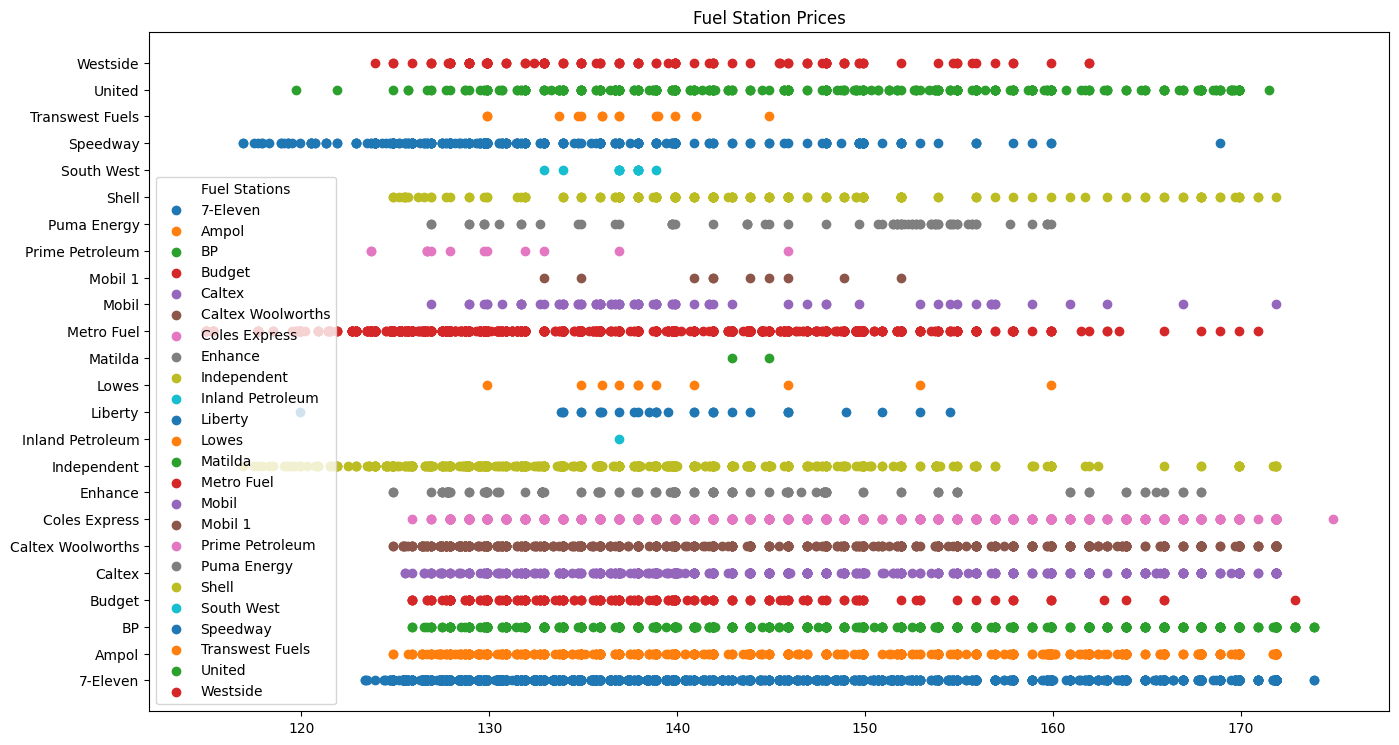

In [22]:
for name, data in df_withtime.groupby("Brand"):
    plt.scatter(data.Price_U91, data.Brand, label = name)
plt.legend(title='Fuel Stations')
plt.title('Fuel Station Prices')

In this graph, you will be able to see the fuel prices at each fuel stations owned by different companies. Metro and Speedway sell cheaper fuel out of all the companies following by Independent. Instead, Coles does sell a bit more expensive than other fuel stations. This could be becuase they didn't own any fuel depots or it is just to match the discounts they have. On the other hand, Caltax owned the most fuel stations, it's prices are still slightly more expensive than BP.

Next up is a clearer plot for stations that sold their fuel over 160.0 and under 130.0. You can see that Coles doesn't actually own that many fuel stations comparing to Caltax.

Text(0.5, 1.0, 'Fuel Station Prices over 160')

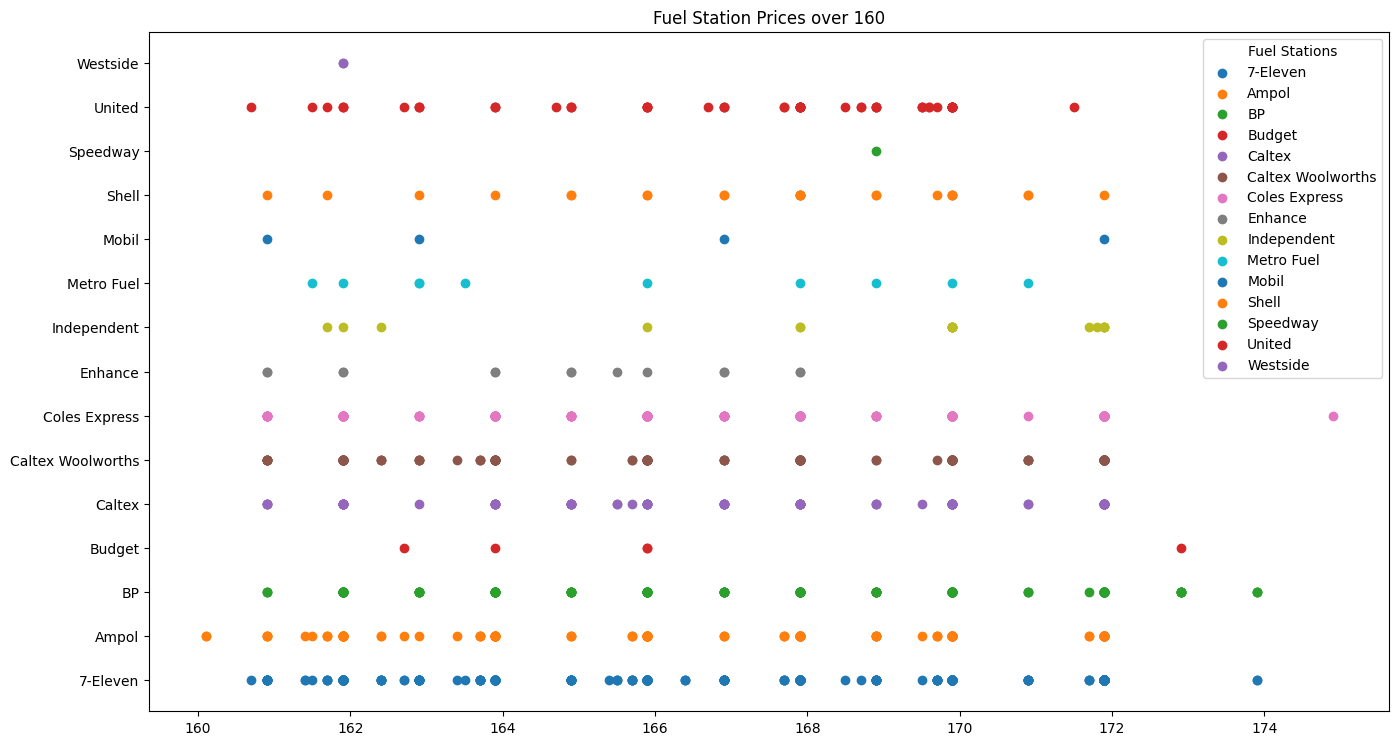

In [23]:
for name, data in price_frame_df.groupby("Brand"):
    plt.scatter(data.Price_U91, data.Brand, label = name)
plt.legend(title='Fuel Stations')
plt.title('Fuel Station Prices over 160')

And the cheaper side.

Text(0.5, 1.0, 'Fuel Station Prices under 130')

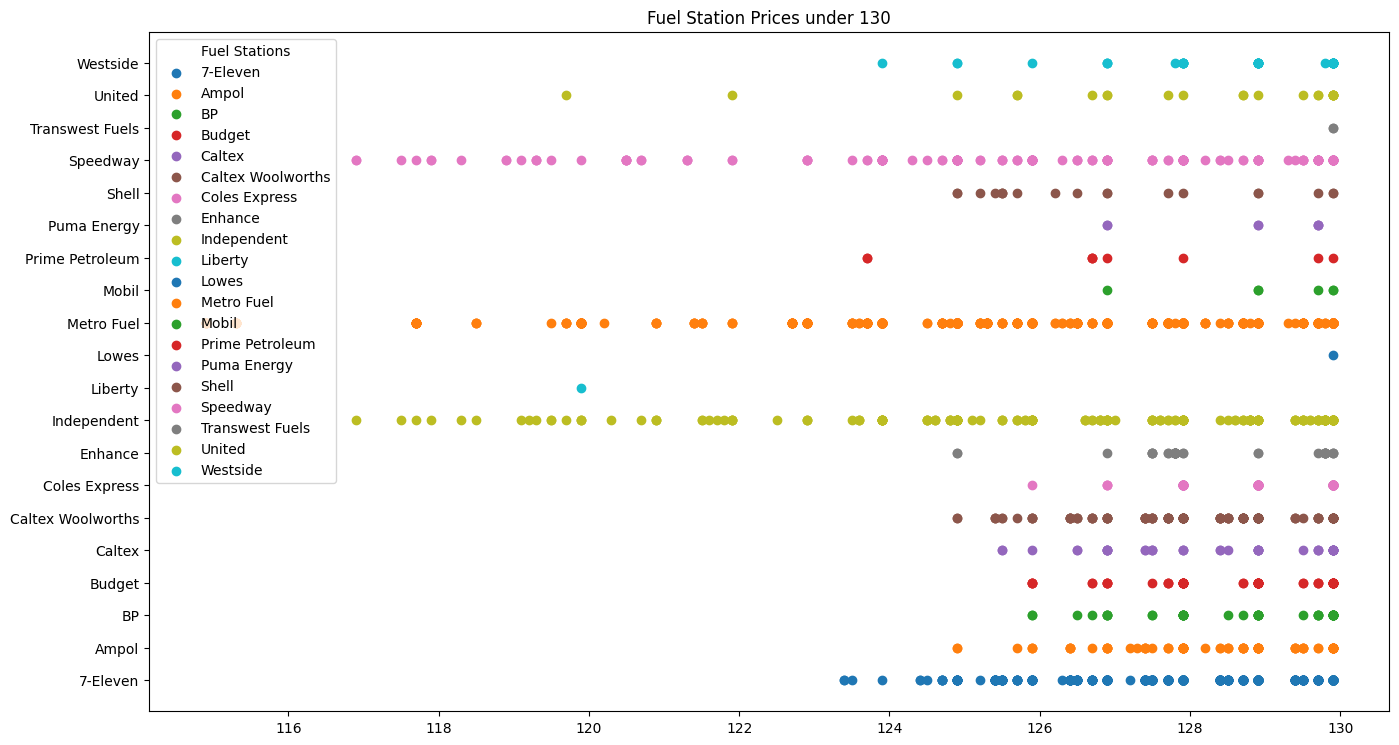

In [37]:
for name, data in price_frame_df_low.groupby("Brand"):
    plt.scatter(data.Price_U91, data.Brand, label = name)
plt.legend(title='Fuel Stations')
plt.title('Fuel Station Prices under 130')

Also something interesting to look at. The price trend for Unleaded 91 throughout the whole month. The cheapest average prices are on Saturdays and Sundays. 

Text(0.5, 1.0, 'Price trend for Unleaded 91')

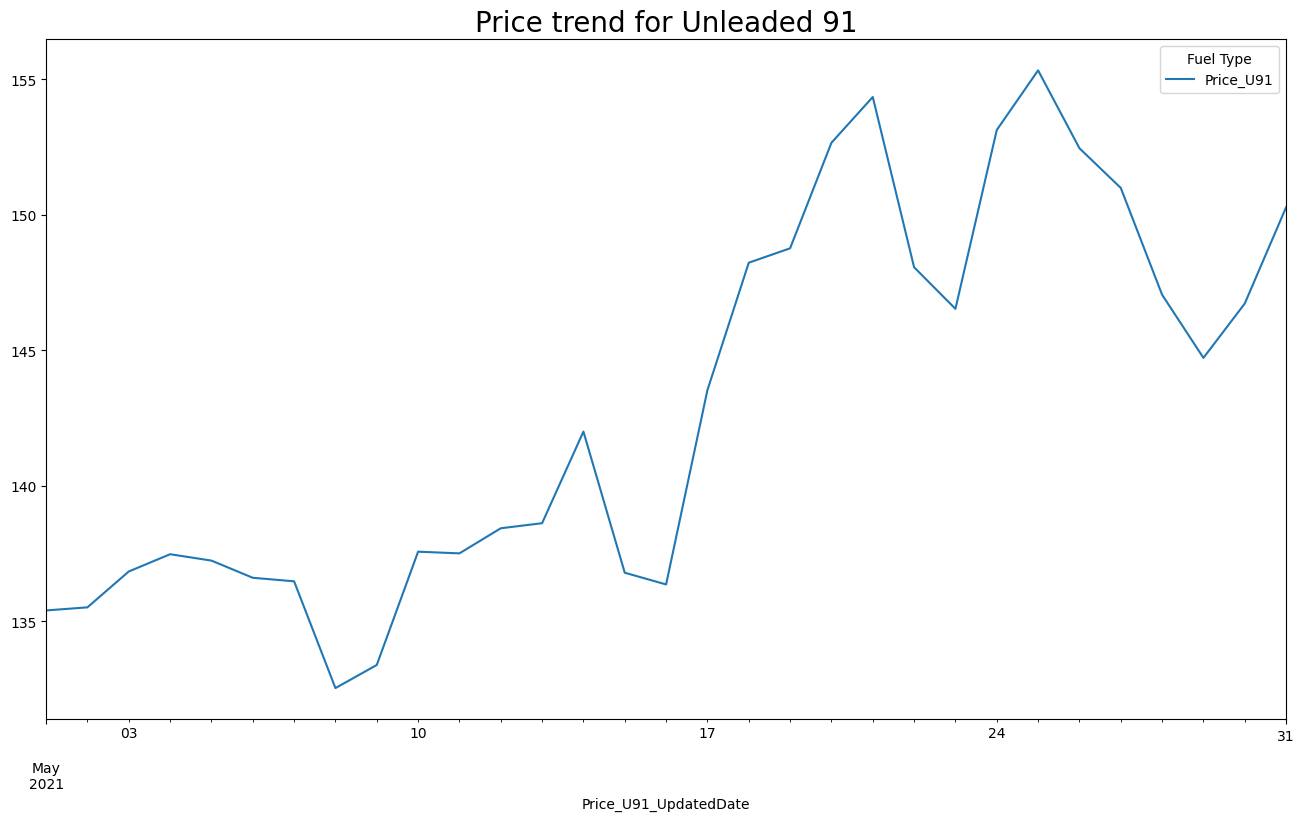

In [25]:
reshaped_df.set_index("Price_U91_UpdatedDate").groupby(pd.Grouper(freq="D")).mean().Price_U91.plot()
plt.legend(title='Fuel Type')
plt.title("Price trend for Unleaded 91", fontsize=20)

Text(0.5, 1.0, 'Price trend for Premium 98')

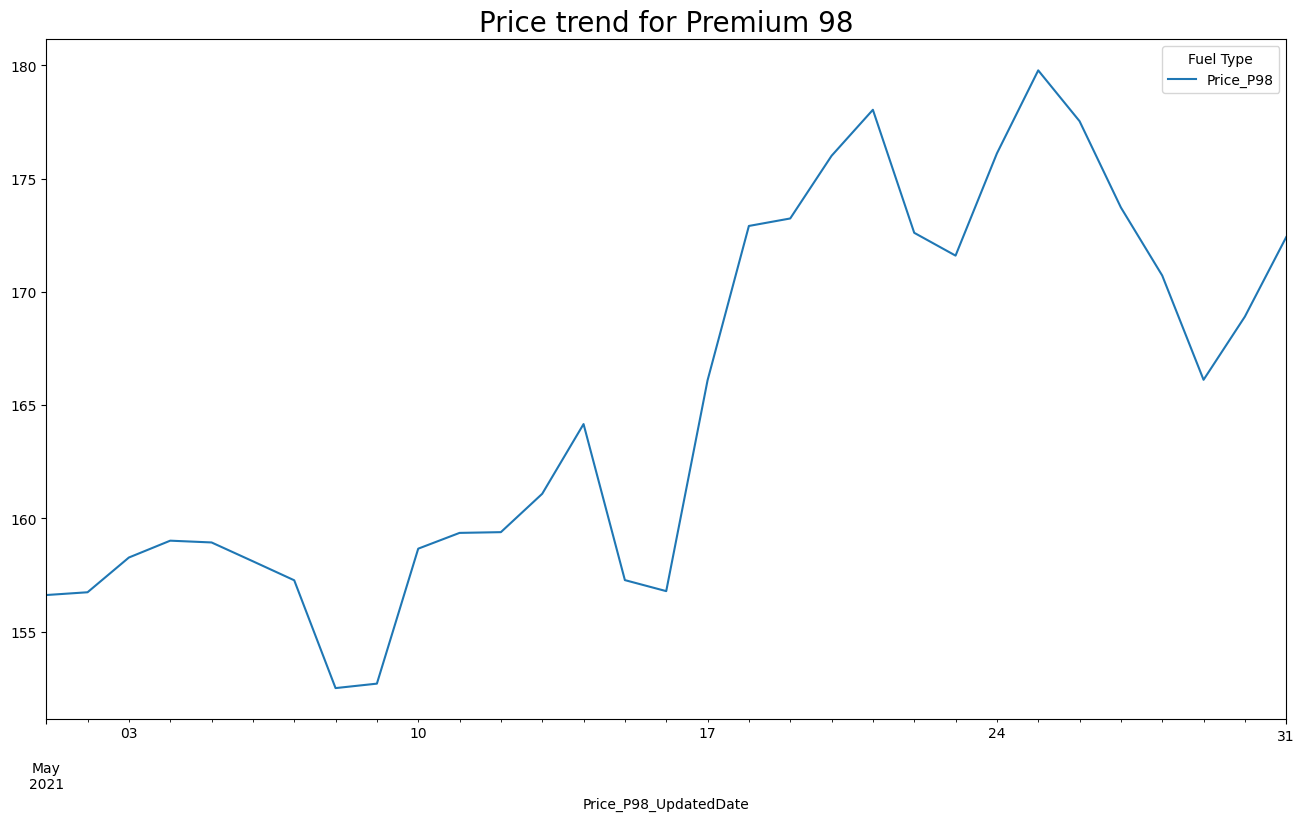

In [26]:
reshaped_df.set_index("Price_P98_UpdatedDate").groupby(pd.Grouper(freq="D")).mean().Price_P98.plot()
plt.legend(title='Fuel Type')
plt.title("Price trend for Premium 98", fontsize=20)

As you can see when they adjust the price for one type of fuel, the other goes up as well on the same day. The two graphs looks similar!

This is a map showing the location of fuel depots. 

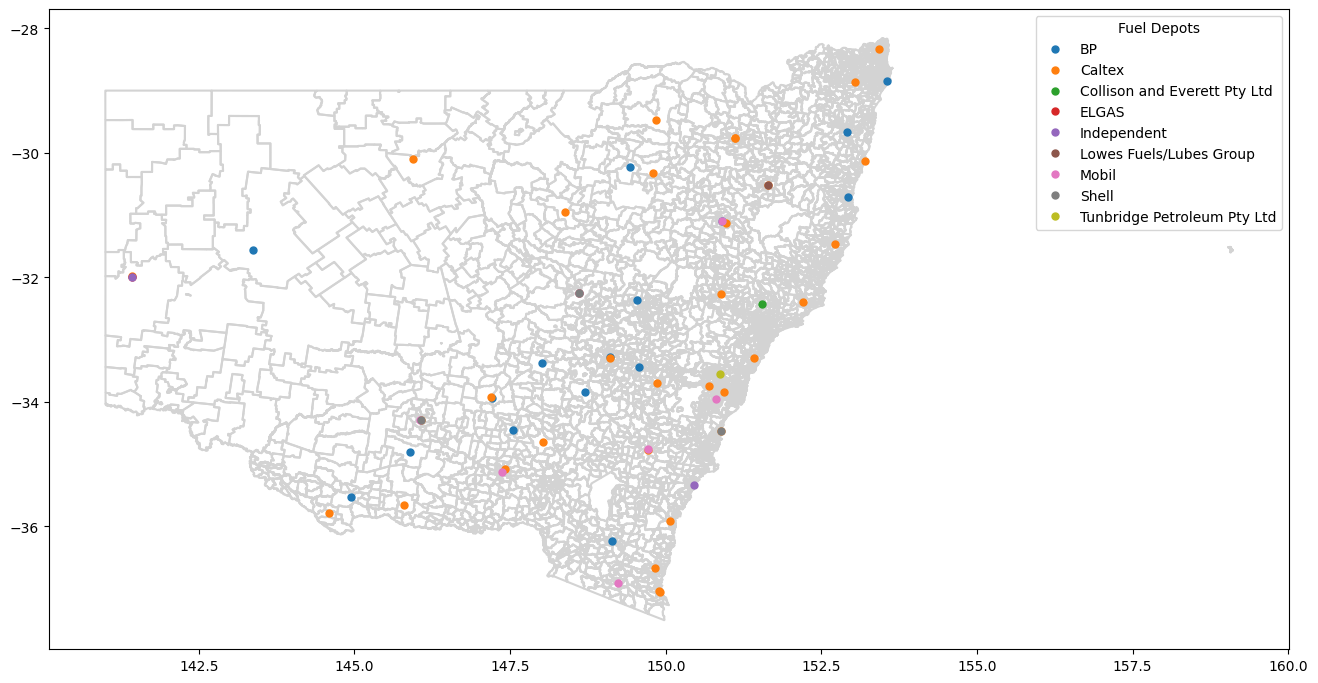

In [27]:
nsw_map = burbs.geometry.boundary.plot(edgecolor='lightgrey')
owners = fuel_depots.groupby("OWNER")
for name, owner in owners:
    plt.plot(owner.LONGITUDE, owner.LATITUDE, marker = 'o', linestyle='', markersize=5, label=name)
plt.legend(title='Fuel Depots')

This map includes the location of fuel stations and fuel depots.

Text(0.5, 1.0, 'NSW Map with Fuel Stations and Depots')

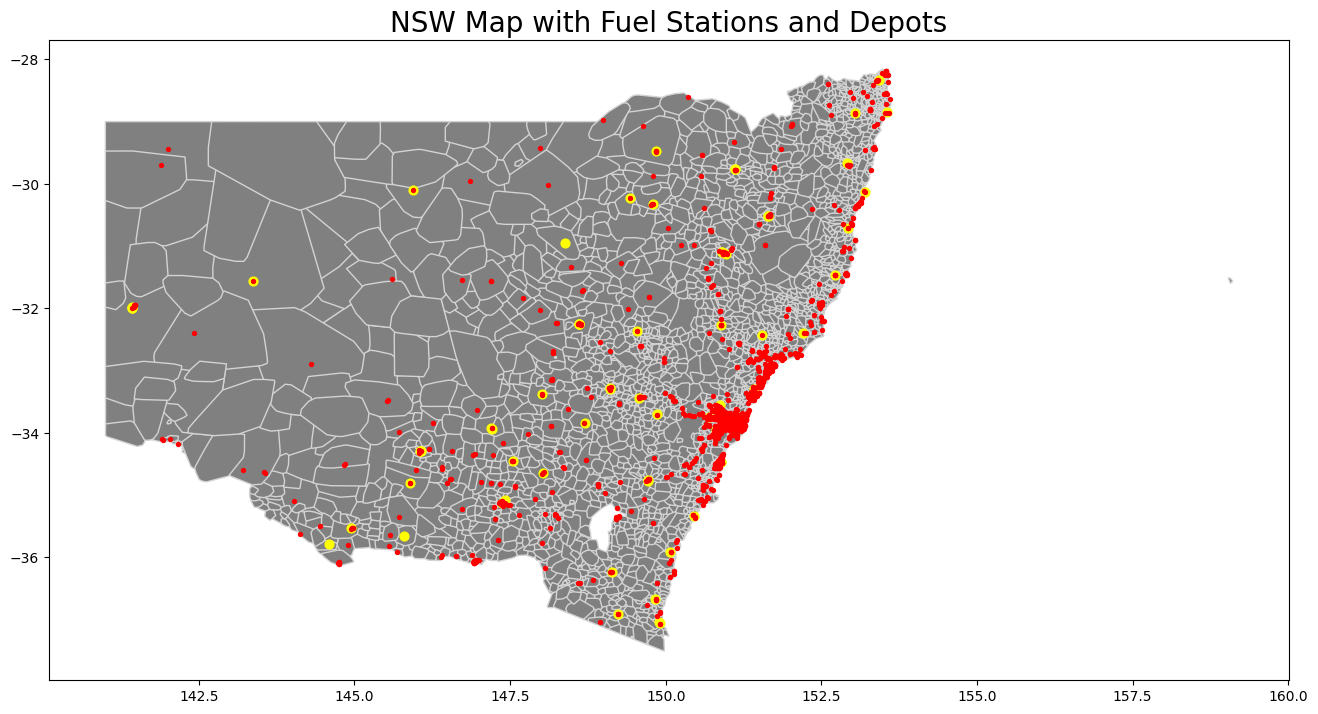

In [28]:
nsw_map = burbs.geometry.convex_hull.plot(facecolor='grey', edgecolor='lightgrey')
fuel_depots_geo.plot(ax=nsw_map, c="yellow", markersize=40)
fuel_station_coordinates_geo.plot(
    ax=nsw_map, c="red", markersize=8, legend=True)

plt.title("NSW Map with Fuel Stations and Depots", fontsize = 20)


As you can see, fuel stations are gathered in Sydney. New Castle has quite a fair amount as well.

In [29]:
fuel_depots.head()

OBJECTID FEATURETYPE                                        DESCRIPTION  \
0         1  Fuel Depot  A facility used for the bulk storage of petrol...   
1         2  Fuel Depot  A facility used for the bulk storage of petrol...   
2         3  Fuel Depot  A facility used for the bulk storage of petrol...   
3         4  Fuel Depot  A facility used for the bulk storage of petrol...   
4         5  Fuel Depot  A facility used for the bulk storage of petrol...   

        CLASS  FID                      NAME OPERATIONALSTATUS  \
0  Fuel Depot   52                      Eden       Operational   
1  Fuel Depot   53  Temora Fuel Distributors       Operational   
2  Fuel Depot   54                     Dubbo       Operational   
3  Fuel Depot   55                     Dubbo       Operational   
4  Fuel Depot   56                     Dubbo       Operational   

                   OPERATOR   OWNER                 ADDRESS  SUBURB  \
0                    Caltex  Caltex   Lot 23 Ben Boyd Drive    Eden   
1  Temora Fuel Distributors      BP       9 Ironbark Street  Temora   
2          Inland Petroleum      BP      105 Erskine Street   Dubbo   
3   Lowes Petroleum Service   Mobil      107 Erskine Street   Dubbo   
4                     Shell   Shell  109-113 Erskine Street   Dubbo   

             STATE  SPATIALCONFIDENCE   REVISED  \
0  New South Wales                  4  20121004   
1  New South Wales                  5  20121004   
2  New South Wales                  5  20121004   
3  New South Wales                  5  20121004   
4  New South Wales                  5  20121004   

                                             COMMENT   LATITUDE   LONGITUDE  \
0  8 lay Down tanks + 1 lay down tank possibly fo... -37.038479  149.891540   
1  3 med + 1 med + 1 separate lay down tank, 2 me... -34.447685  147.552978   
2  Station as well, 1 Terminal sized upright + 10... -32.244324  148.610268   
3  Station as well, 5 large + 2 small upright tan... -32.244473  148.611153   
4  Station as well, 1 terminal sized + 1 small up... -32.244732  148.612396   

                      geometry  
0  POINT (149.89154 -37.03848)  
1  POINT (147.55298 -34.44769)  
2  POINT (148.61027 -32.24432)  
3  POINT (148.61115 -32.24447)  
4  POINT (148.61240 -32.24473)

Here's a map with gradients. The darker the green is the higer the price. 

Text(0.5, 1.0, 'Fuel Depot locations and Fuel Prices')

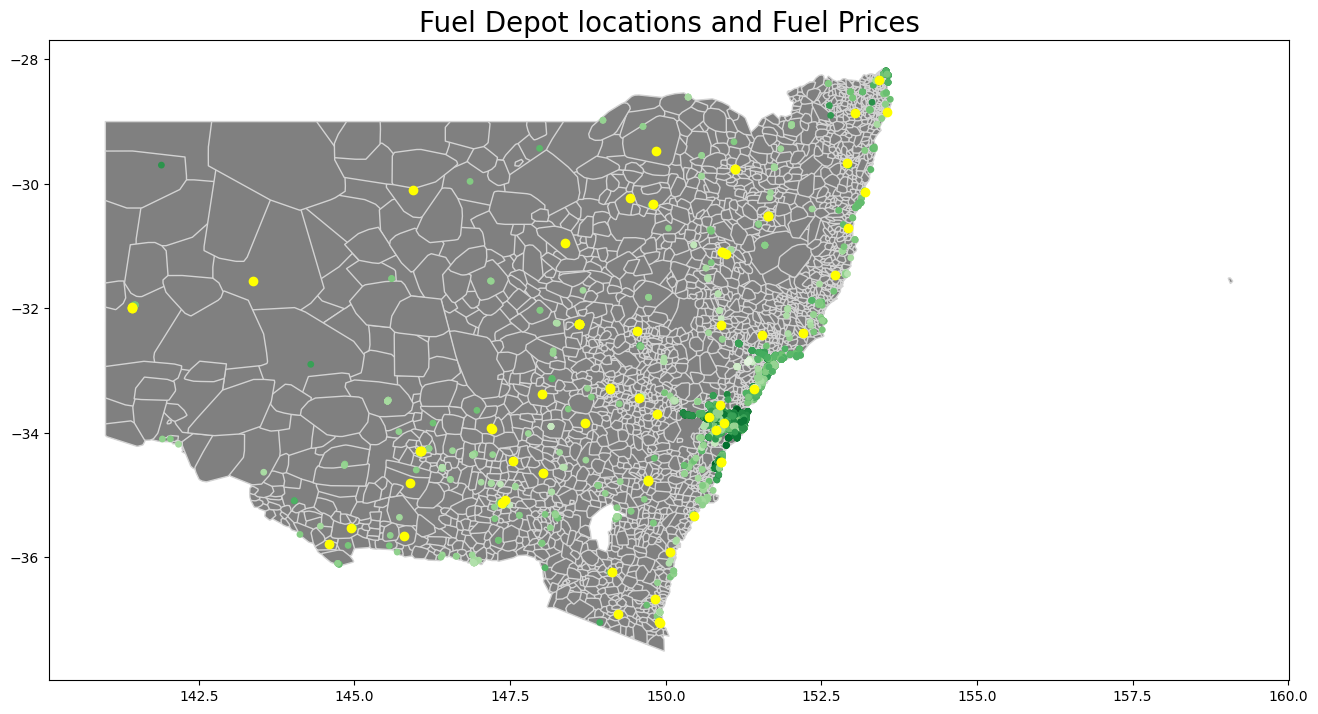

In [38]:
nsw_map = burbs.geometry.convex_hull.plot(facecolor='grey', edgecolor='lightgrey')
plt.scatter(new_fuel_station_coordinates.longitude, new_fuel_station_coordinates.latitude, c=new_fuel_station_coordinates.Price_U91, cmap='Greens', s=15)
plt.scatter(fuel_depots.LONGITUDE, fuel_depots.LATITUDE, c = "yellow")

plt.title("Fuel Depot locations and Fuel Prices", fontsize=20)

Now, lets look at the location for each fuel depots and who owned them. The depots owned by BP are mostly in rural areas whereas Caltax has two of their depots in Sydney. 

In [31]:
def new_legend_color(n):
    if n < 119:
        return "Group 0 - 119"
    elif 120 < n < 129:
        return "Group 120-129"
    elif 130 < n < 139:
        return "Group 130-139"
    elif 140 < n <149:
        return "Group 140-149"
    elif 150 < n <159:
        return "Group 150-159"
    elif 160 < n <200:
        return "Group 160-200"
    elif n == str:
        return n

new_fuel_station_coordinates["Price_Group_New"] = new_fuel_station_coordinates.Price_U91.apply(new_legend_color)
new_fuel_station_coordinates.sample(10)

Unnamed: 0                                            Address  \
14406       19876          16 Princes Highway, FAIRY MEADOW NSW 2519   
13184       18226           210-214 Wollombi Road, Cessnock NSW 2325   
8958        12398              9 Bay Village Rd, BATEAU BAY NSW 2261   
9086        12591               191-193 Cessnock Rd, Weston NSW 2326   
2084         2969               128 Barker Street, Randwick NSW 2031   
1486         2139  630-634 Liverpool Road, Strathfield South NSW ...   
309           456           504 Pittwater road, North Manly NSW 2100   
532           768             434 Crown St, Wollongong West NSW 2500   
5311         7482                 32 Princes Hwy, Arncliffe NSW 2205   
14873       20527         348 Elizabeth Dr, MOUNT PRITCHARD NSW 2170   

                   Brand  Postcode  Price_DL Price_DL_UpdatedDate  Price_E10  \
14406         Metro Fuel    2519.0       NaN                  NaN      137.9   
13184           7-Eleven    2325.0       NaN                  NaN      126.9   
8958   Caltex Woolworths    2261.0       NaN                  NaN      146.9   
9086          Metro Fuel    2326.0     123.9     05/20/2021 18:00      132.5   
2084            7-Eleven    2031.0       NaN                  NaN      136.9   
1486       Coles Express    2136.0       NaN                  NaN      126.9   
309                   BP    2100.0       NaN                  NaN      142.9   
532        Coles Express    2500.0       NaN                  NaN      134.9   
5311            Speedway    2205.0       NaN                  NaN      123.9   
14873           Speedway    2170.0       NaN                  NaN      136.9   

      Price_E10_UpdatedDate  Price_E85 Price_E85_UpdatedDate  ...  \
14406      05/30/2021 17:16        NaN                   NaN  ...   
13184       05/28/2021 6:45        NaN                   NaN  ...   
8958       05/20/2021 13:05        NaN                   NaN  ...   
9086       05/20/2021 18:00        NaN                   NaN  ...   
2084        05/05/2021 7:36        NaN                   NaN  ...   
1486        05/04/2021 8:30        NaN                   NaN  ...   
309        05/01/2021 15:05        NaN                   NaN  ...   
532         05/02/2021 9:30        NaN                   NaN  ...   
5311       05/11/2021 19:58        NaN                   NaN  ...   
14873       05/31/2021 9:46        NaN                   NaN  ...   

       Price_P98_UpdatedDate Price_PDL  Price_PDL_UpdatedDate Price_U91  \
14406       05/30/2021 17:16       NaN                    NaN     139.9   
13184        05/28/2021 6:45       NaN                    NaN     128.9   
8958        05/20/2021 13:05       NaN                    NaN     148.9   
9086                     NaN     123.9       05/20/2021 18:00       NaN   
2084         05/05/2021 7:36       NaN                    NaN     138.9   
1486         05/04/2021 8:30       NaN                    NaN     128.9   
309         05/01/2021 15:05       NaN                    NaN       NaN   
532          05/02/2021 9:30       NaN                    NaN       NaN   
5311                     NaN       NaN                    NaN       NaN   
14873                    NaN       NaN                    NaN       NaN   

       Price_U91_UpdatedDate               ServiceStationName  \
14406       05/30/2021 17:16     Metro Petroleum Fairy Meadow   
13184        05/28/2021 6:45                7-Eleven Cessnock   
8958        05/20/2021 13:05     Caltex Woolworths Bateau Bay   
9086                     NaN                     Metro Weston   
2084         05/05/2021 7:36                7-Eleven Randwick   
1486         05/04/2021 8:30  Coles Express Strathfield South   
309                      NaN                   BP North Manly   
532                      NaN    Coles Express Wollongong West   
5311                     NaN               Speedway Arncliffe   
14873                    NaN            Speedway Mt Pritchard   

                  Suburb   lati

To follow that up, I have grouped the prices and plot them onto the map. As you can see, Sydney and Wollongong's fuel stations sell the most expensive fuel. It could be the land cost or demand. Followed by New Castle.

This maps sorted the fuel prices into groups and plotted with different colours.

Text(0.5, 1.0, 'Price Groups for fuel stations')

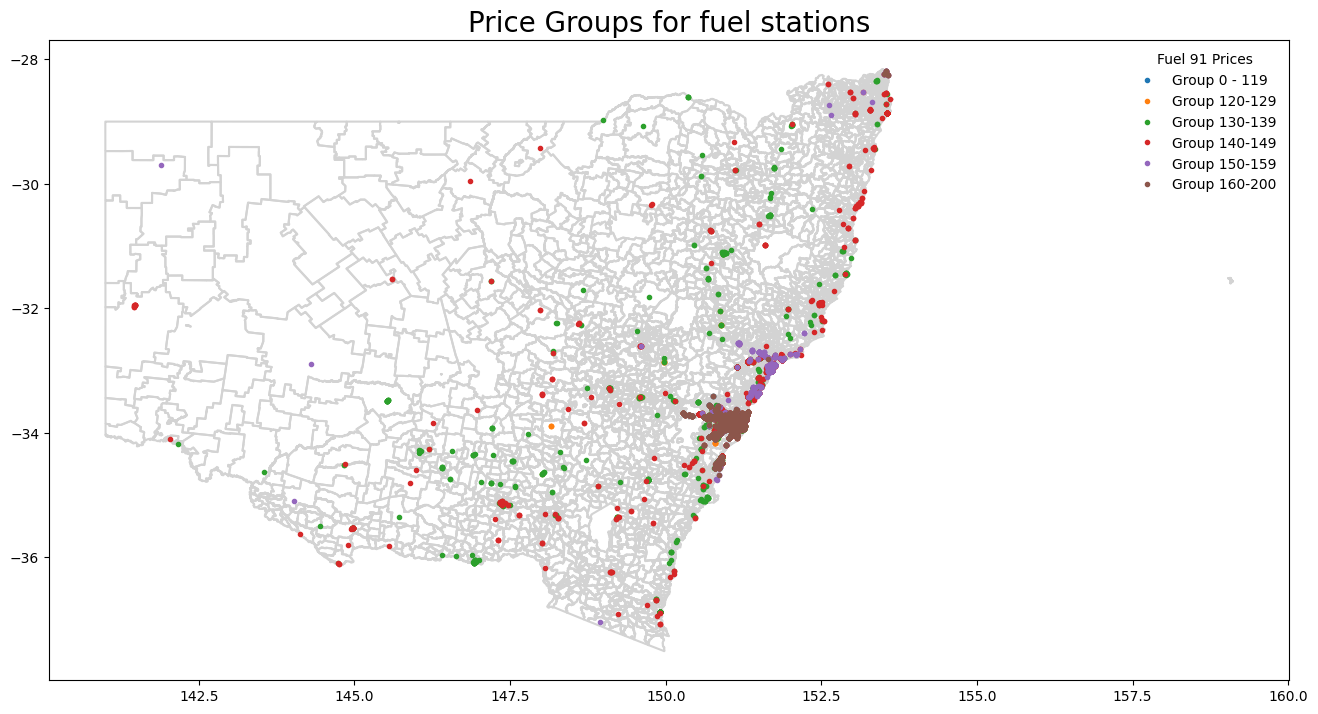

In [32]:
nsw_map = burbs.geometry.boundary.plot(edgecolor='lightgrey')
groups = new_fuel_station_coordinates.groupby("Price_Group_New")
for name, group in groups:
    plt.plot(group.longitude, group.latitude, marker = "o", linestyle='', markersize = 3, label=name)
plt.legend(scatterpoints=1, frameon=False, title='Fuel 91 Prices')
plt.title('Price Groups for fuel stations', fontsize=20)

Now back to our original question, does fuel stations that are near to a fuel depot sell cheaper fuel prices? The map below indicates that stations near depots do sell their fuel with a cheaper price, however, the stations are also located in the rural areas which have less demand. 

Text(0.5, 1.0, 'Price Groups for fuel stations with fuel depots')

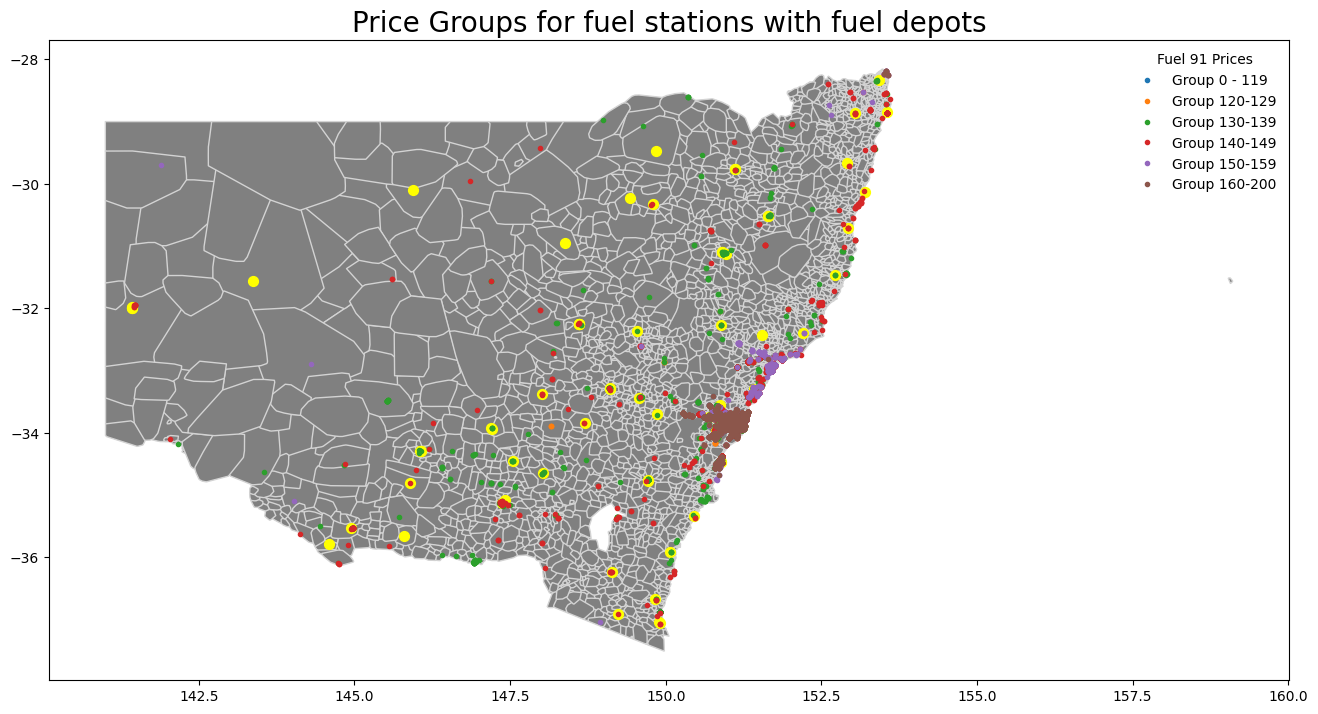

In [33]:
nsw_map = burbs.geometry.convex_hull.plot(facecolor='grey', edgecolor='lightgrey')
groups = new_fuel_station_coordinates.groupby("Price_Group_New")
for name, group in groups:
    plt.plot(group.longitude, group.latitude, marker = "o", linestyle='', markersize = 3, label=name)
plt.scatter(fuel_depots.LONGITUDE, fuel_depots.LATITUDE, c = "yellow", s=50)
plt.legend(scatterpoints=1, frameon=False, title='Fuel 91 Prices')
plt.title('Price Groups for fuel stations with fuel depots', fontsize=20)

In [34]:
fuel_depots.head()

OBJECTID FEATURETYPE                                        DESCRIPTION  \
0         1  Fuel Depot  A facility used for the bulk storage of petrol...   
1         2  Fuel Depot  A facility used for the bulk storage of petrol...   
2         3  Fuel Depot  A facility used for the bulk storage of petrol...   
3         4  Fuel Depot  A facility used for the bulk storage of petrol...   
4         5  Fuel Depot  A facility used for the bulk storage of petrol...   

        CLASS  FID                      NAME OPERATIONALSTATUS  \
0  Fuel Depot   52                      Eden       Operational   
1  Fuel Depot   53  Temora Fuel Distributors       Operational   
2  Fuel Depot   54                     Dubbo       Operational   
3  Fuel Depot   55                     Dubbo       Operational   
4  Fuel Depot   56                     Dubbo       Operational   

                   OPERATOR   OWNER                 ADDRESS  SUBURB  \
0                    Caltex  Caltex   Lot 23 Ben Boyd Drive    Eden   
1  Temora Fuel Distributors      BP       9 Ironbark Street  Temora   
2          Inland Petroleum      BP      105 Erskine Street   Dubbo   
3   Lowes Petroleum Service   Mobil      107 Erskine Street   Dubbo   
4                     Shell   Shell  109-113 Erskine Street   Dubbo   

             STATE  SPATIALCONFIDENCE   REVISED  \
0  New South Wales                  4  20121004   
1  New South Wales                  5  20121004   
2  New South Wales                  5  20121004   
3  New South Wales                  5  20121004   
4  New South Wales                  5  20121004   

                                             COMMENT   LATITUDE   LONGITUDE  \
0  8 lay Down tanks + 1 lay down tank possibly fo... -37.038479  149.891540   
1  3 med + 1 med + 1 separate lay down tank, 2 me... -34.447685  147.552978   
2  Station as well, 1 Terminal sized upright + 10... -32.244324  148.610268   
3  Station as well, 5 large + 2 small upright tan... -32.244473  148.611153   
4  Station as well, 1 terminal sized + 1 small up... -32.244732  148.612396   

                      geometry  
0  POINT (149.89154 -37.03848)  
1  POINT (147.55298 -34.44769)  
2  POINT (148.61027 -32.24432)  
3  POINT (148.61115 -32.24447)  
4  POINT (148.61240 -32.24473)

In [35]:
fuel_station_coordinates.head()

Number                                       station  \
0       0  702-704 Warringah Road, Forestville NSW 2087   
1       2            125 Brunker Rd, Adamstown NSW 2289   
2       3            323 River Street, BALLINA NSW 2478   
3       4      656 Warringah Road, FORESTVILLE NSW 2087   
4       5          198 Hill End Road, Doonside NSW 2767   

                                            location   latitude   longitude  \
0  Warringah Road, Forestville, Sydney, Northern ... -33.760921  151.216115   
1  Brunker Road, Adamstown, Newcastle, Newcastle ... -32.943960  151.722761   
2  323, River Street, Ballina CBD, Ballina, Balli... -28.866000  153.550280   
3  Warringah Road, Forestville, Sydney, Northern ... -33.760921  151.216115   
4  Hill End Road, Doonside, Sydney, Blacktown Cit... -33.761139  150.869841   

        owner            Price_U91        Price_P98  \
0  Metro Fuel                137.9            155.9   
1    Westside  Not Selling U91                158.9   
2  Metro Fuel                142.9            161.9   
3  Metro Fuel                137.9  Not Selling P98   
4  Metro Fuel  Not Selling U91      Not Selling P98   

                      geometry  
0  POINT (151.21612 -33.76092)  
1  POINT (151.72276 -32.94396)  
2  POINT (153.55028 -28.86600)  
3  POINT (151.21612 -33.76092)  
4  POINT (150.86984 -33.76114)

Lastly, a folium map that shows how fuel stations are distributed across NSW and a closer look at the fuel prices.

In [36]:
map_in_nsw = folium.Map(location=[-33.8688, 151.2093],  zoom_start=10)
for (index, row) in fuel_depots.iterrows():
    folium.Marker(location=[row.loc["LATITUDE"], row.loc["LONGITUDE"]],
                popup=row.loc["OWNER"], tooltip="Fuel Depots", type_color='green').add_to(map_in_nsw)
    folium.CircleMarker(location=[row.loc["LATITUDE"], row.loc["LONGITUDE"]], radius=100).add_to(map_in_nsw)
for (index, row) in fuel_station_coordinates.iterrows():
    folium.Marker(location=[row.loc["latitude"], row.loc["longitude"]],
                popup=row.loc["owner"]+" "+"Price U91-"+row.loc["Price_U91"]+" "+"Price P98-"+row.loc["Price_P98"], tooltip="Fuel stations").add_to(map_in_nsw)
map_in_nsw

BP in Manly furthest away from the fuel depots

<img src ="Manly price.png"/>

BP at Cabramatta new a depot

<img src ="Price near a fuel station.png"/>

Caltex at Bathurst (Outside of Sydney)

<img src ="South Bathurst.png"/>


Metro in Bathurst

<img src ="South Bathurst 1.png"/>

Caltax in Blayney

<img src ="Blayney no depot.png"/>

Shell in Cowra

<img src ="Cowra.png"/>

United in Corwa

<img src ="Cowra 1.png"/>

In the end, some of the fuel prices do get cheaper around fuel depots but there are more aspects to consider

● Rental Cost
● Delivery Cost
● Location consideration

Rural Areas:
● Old fuel with a lower price
● Less demand on fuel
● Cheaper cost

City:
● High demand
● Up-to-date fuel
● Delivery cost higher
● Contolled by the ACCC (Australian Competition and Consumer Commission)


Fuel stations near a fuel depot will mostly be cheaper but the consideration will be the travel distance. 

Thank you!